In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

## Define growing season length


In [7]:
def growing_season_length(ds):

    n_lats = len(ds.lat)
    n_lons = len(ds.lon)
    n_years = int(len(ds.time)/365)

    growing_season_length = np.zeros((n_lats, n_lons, n_years))
    temp_threshold = 273.15 + 5 # Temperature threshold for growing
    time_threshold_start = 7 # Time threshold with growing conditions for growing season to start
    time_threshold_end = 7 # Time threshold with non-growing conditions for growing season to end

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                ds1 = ds.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year
                grow = ds1.values >= temp_threshold # Growing conditions
                non_grow = ds1.values < temp_threshold # Non-growing conditions

                grow_idx = list(np.where(grow)[0]) # Find indexes of different groweing conditions
                non_grow_idx = list(np.where(non_grow)[0]) # Find indexes of non-growing conditions

                if not grow_idx:
                    # No growing season
                    length = 0
                elif not non_grow_idx:
                    # Only growing season
                    length = 365
                else:
                    non_grow_idx = np.array(non_grow_idx+[364]) # Add end point of the year to make sure to catch grouped indexes
                    grow_idx = np.array(grow_idx+[364]) # Add end point of the year to make sure to catch grouped indexes
                    # Find the first day when the differences in days between non-growing conditions is more than time threshold
                    # The start of the growing season is one week after this
                    start_of_GSL = non_grow_idx[np.where(np.diff(non_grow_idx) >= time_threshold_start)]
                    start_of_GSL = start_of_GSL[0] + 7
                    print("Start: ", start_of_GSL)
                
                    # Find when the differences between growing conditions indexes is larger than time threshold
                    # Choose the first sufficiently long non-growing period after the growing season start
                    
                    end_of_GSL = grow_idx[np.where(np.diff(grow_idx) >= time_threshold_end)]
                    if np.any(end_of_GSL > start_of_GSL):
                        end_of_GSL = end_of_GSL[np.where(end_of_GSL > start_of_GSL)][0]
                    else:
                        end_of_GSL = 364
                    print("End: ", end_of_GSL)
                    length = end_of_GSL-start_of_GSL + 1 # Add 1 to include the whole growing season period
                
                print("Length: ", length)
                growing_season_length[lat, lon, year] = length
        
    return growing_season_length

## Load relevant climate variables from CMIP6 data

In [5]:
# Define dataset specifics

model_scenario_name = 'NorESM2-LM_ssp126' # Choose a model and SSP scenario
area_name = 'norway' # Choose an area

# Defines start and end of time slice by picking 20 years before and 20 years after abrupt SPG cooling
if model_scenario_name == 'NorESM2-LM_ssp126':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp126':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'MRI-ESM2_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
else:
    print("This dataset is not considered in the current study, but can be added to the analysis")

if area_name == 'norway':
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'germany':
    southern_lat = 46.5; northern_lat = 55.5
    western_lon = 5; eastern_lon = 15
elif area_name == 'global':
    southern_lat = -90; northern_lat = 90
    western_lon = 0; eastern_lon = 360
else:
    print("This area is not predefined in the current study, but can be added to the analysis")

data_folder = '../CMIP6_data/' # Folder where downloaded CMIP6 data is stored
save_folder = '../climatic_indices/' # Folder where climate indices should be saved
os.makedirs(save_folder, exist_ok=True) 


# Load mean daily temperature data

files = glob.glob(data_folder+'tas_day_'+model_scenario_name+'*')
files.sort()
tas = xr.open_mfdataset(files)

temp = tas.tas.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

temp.load()

<xarray.DataArray 'tas' (time: 14601, lat: 8, lon: 13)> Size: 6MB
array([[[273.6078 , 271.92917, 269.75214, ..., 264.8342 , 265.37787,
         264.6559 ],
        [273.25977, 269.7192 , 260.19144, ..., 269.10968, 266.01303,
         263.83633],
        [274.05716, 270.54947, 261.56357, ..., 265.27667, 264.38855,
         263.0994 ],
        ...,
        [271.44284, 272.73035, 273.40005, ..., 259.56985, 257.64374,
         257.70404],
        [270.45297, 272.12524, 272.73624, ..., 262.007  , 262.7555 ,
         265.78665],
        [269.77036, 270.78302, 270.69556, ..., 268.39853, 269.78143,
         270.23767]],

       [[274.28915, 272.70673, 270.70712, ..., 265.8188 , 264.45636,
         263.23935],
        [274.0896 , 270.94556, 260.52478, ..., 269.81973, 265.5166 ,
         264.121  ],
        [274.41818, 270.5146 , 261.3528 , ..., 263.30823, 261.21735,
         260.9207 ],
...
        [273.15012, 274.7675 , 274.88525, ..., 261.56128, 263.17438,
         266.47687],
        [270.20892, 272.77176, 274.23306, ..., 262.79138, 266.0678 ,
         268.27914],
        [267.9428 , 271.64536, 273.71866, ..., 270.45767, 270.1975 ,
         269.6443 ]],

       [[278.22296, 277.72293, 276.76358, ..., 266.71356, 264.70483,
         263.60815],
        [277.5271 , 275.15643, 269.30884, ..., 267.98486, 263.76694,
         263.22784],
        [276.36856, 272.88904, 266.14468, ..., 263.27036, 261.67484,
         258.73712],
        ...,
        [274.05316, 274.73846, 274.38525, ..., 263.43094, 263.89023,
         263.1871 ],
        [273.7755 , 274.4857 , 274.47638, ..., 264.54718, 265.26312,
         267.0672 ],
        [272.93927, 274.05746, 274.2377 , ..., 269.70615, 269.98676,
         269.8037 ]]], dtype=float32)
Coordinates:
  * time     (time) object 117kB 2015-01-01 12:00:00 ... 2055-01-01 12:00:00
  * lat      (lat) float64 64B 57.79 59.68 61.58 63.47 65.37 67.26 69.16 71.05
  * lon      (lon) float64 104B 2.5 5.0 7.5 10.0 12.5 ... 25.0 27.5 30.0 32.5
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    original_name:  TREFHT
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-12-06T14:54:06Z altered by CMOR: Treated scalar dime...

In [8]:
# Choose which variable to calculate

variable_name = 'GSL'
unit = 'days'
description = 'Growing season length'
input_values = temp
values = growing_season_length(temp)

# Save data as netcdf file

ds = xr.Dataset(
    data_vars=dict(
        variable=(["lat", "lon", "time"], values)
    ),
    coords=dict(
        lat=input_values[0].lat.values,
        lon=input_values[0].lon.values,
        time=time_array,
    ),
)

ds.time.attrs['units'] = 'year'
ds.lat.attrs['description'] = 'latitude'
ds.lon.attrs['description'] = 'longitude'
ds = ds.rename_vars(dict(variable=variable_name))
ds[variable_name].attrs['units'] = unit
ds[variable_name].attrs['description'] = description

ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
ds

Start:  33
End:  78
Length:  46
Start:  25
End:  53
Length:  29
Start:  67
End:  79
Length:  13
Start:  21
End:  364
Length:  344
Start:  21
End:  78
Length:  58
Start:  48
End:  68
Length:  21
Start:  7
End:  364
Length:  358
Start:  16
End:  49
Length:  34
Start:  15
End:  364
Length:  350
Start:  14
End:  49
Length:  36
Start:  9
End:  41
Length:  33
Start:  36
End:  62
Length:  27
Start:  22
End:  29
Length:  8
Start:  30
End:  89
Length:  60
Start:  26
End:  59
Length:  34
Start:  18
End:  45
Length:  28
Start:  36
End:  51
Length:  16
Start:  8
End:  11
Length:  4
Start:  17
End:  364
Length:  348
Start:  16
End:  364
Length:  349
Start:  66
End:  364
Length:  299
Start:  17
End:  321
Length:  305
Start:  18
End:  57
Length:  40
Start:  33
End:  55
Length:  23
Start:  20
End:  43
Length:  24
Start:  8
End:  20
Length:  13
Start:  22
End:  72
Length:  51
Start:  40
End:  43
Length:  4
Start:  15
End:  72
Length:  58
Start:  34
End:  351
Length:  318
Start:  39
End:  67
Length:  29

<xarray.Dataset> Size: 34kB
Dimensions:  (lat: 8, lon: 13, time: 40)
Coordinates:
  * lat      (lat) float64 64B 57.79 59.68 61.58 63.47 65.37 67.26 69.16 71.05
  * lon      (lon) float64 104B 2.5 5.0 7.5 10.0 12.5 ... 25.0 27.5 30.0 32.5
  * time     (time) int64 320B 2015 2016 2017 2018 2019 ... 2051 2052 2053 2054
Data variables:
    GSL      (lat, lon, time) float64 33kB 46.0 29.0 13.0 ... 98.0 71.0 27.0

Text(0.5, 1.0, 'Change in growing season length')

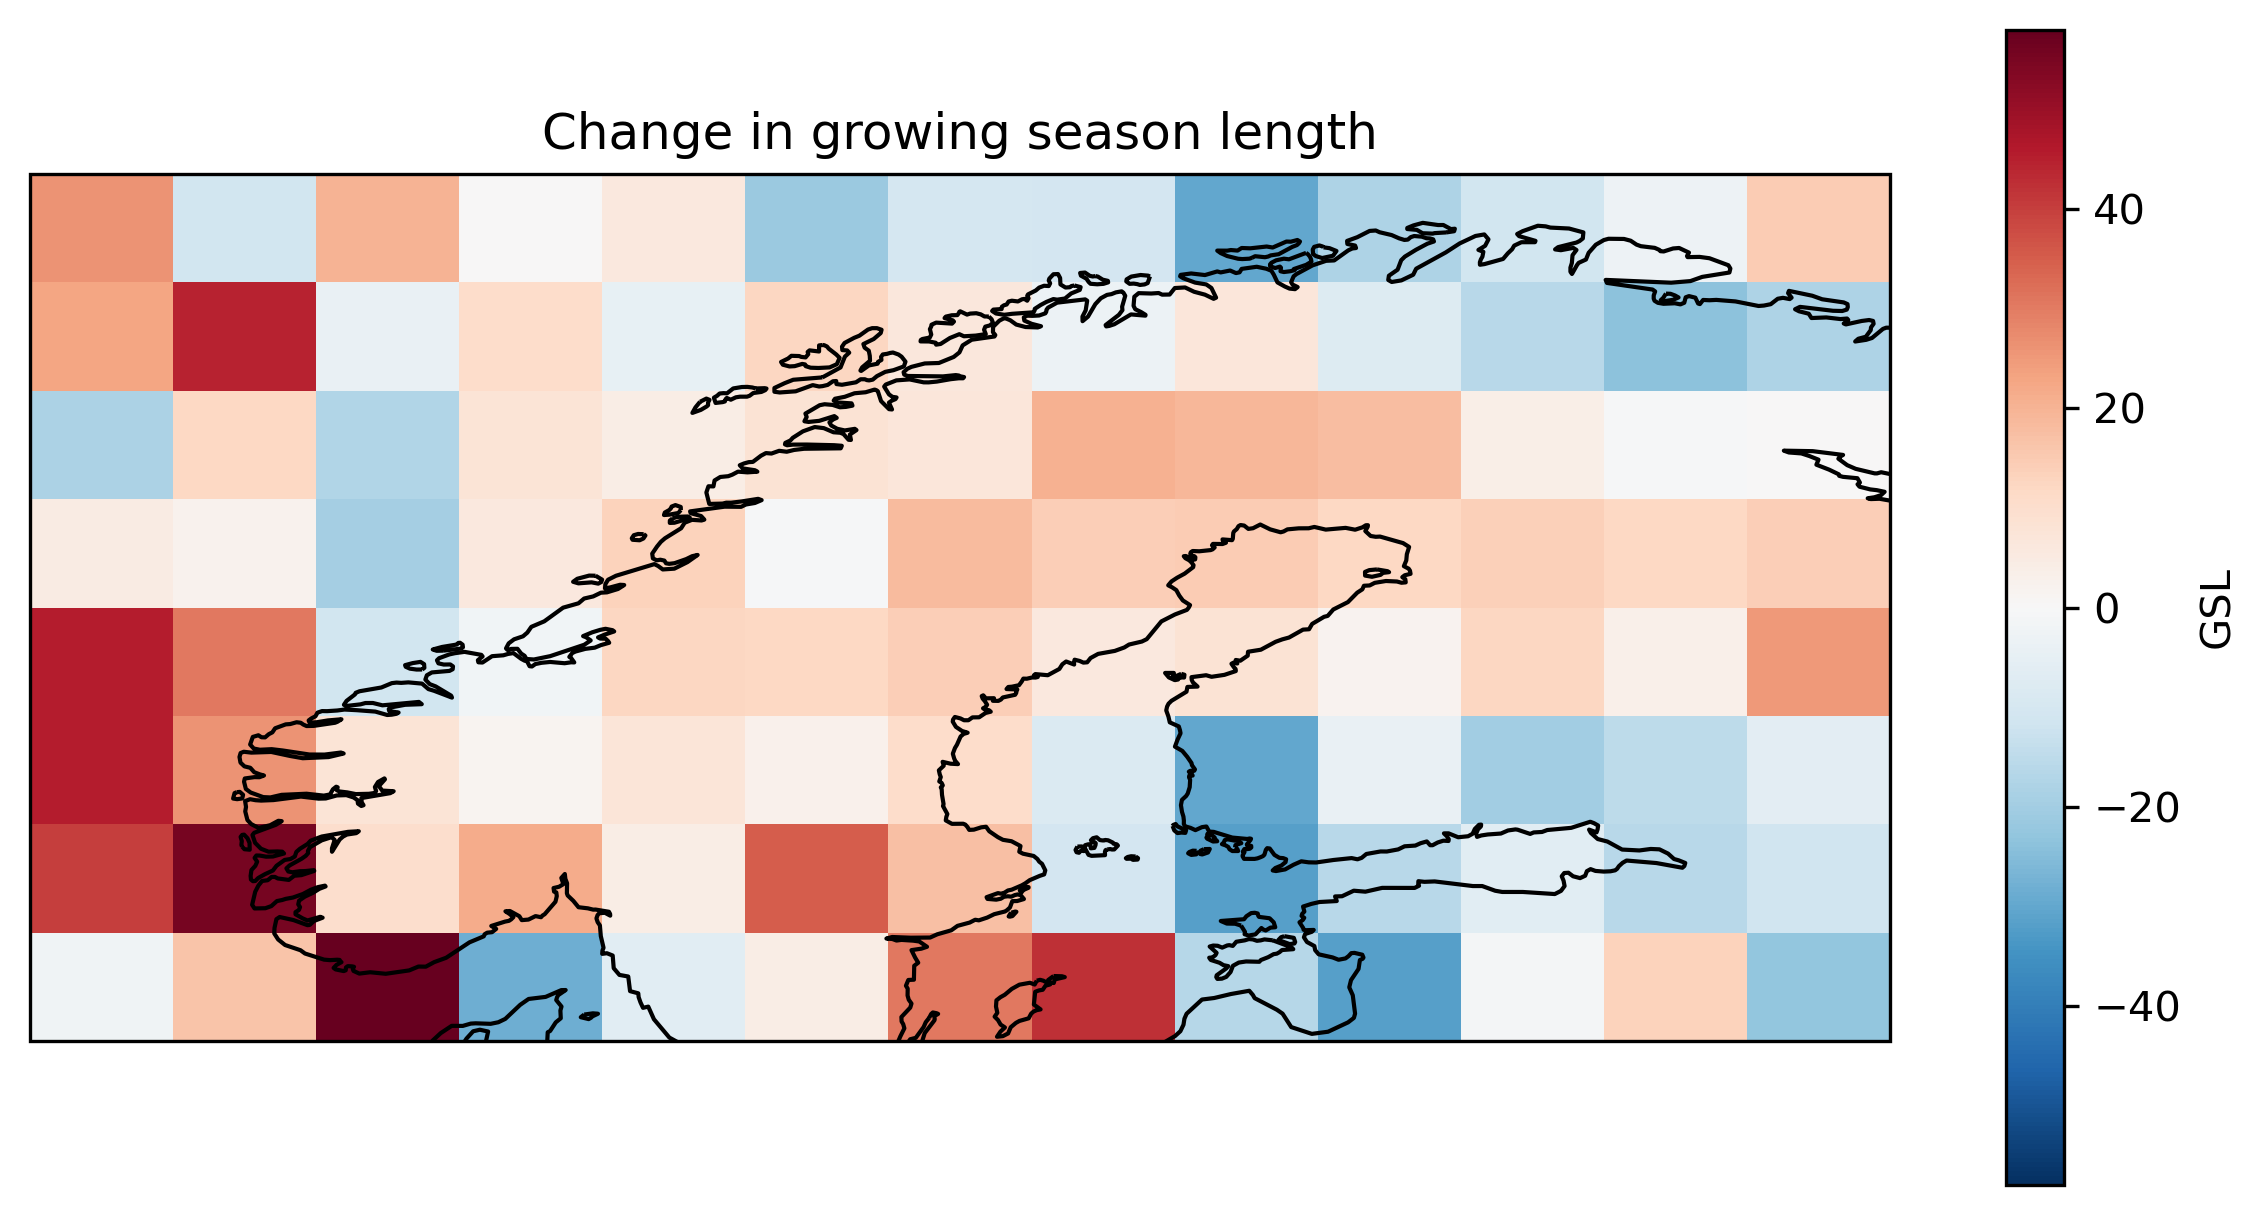

In [11]:
da = xr.open_dataset(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc', decode_timedelta={variable_name : False})
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = da[variable_name].isel(time=slice(20,40)).mean("time") - da[variable_name].isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Change in growing season length")

In [ ]:
ds = tas_NorESM.tas.sel(lat=slice(57.6, 72.8), 
                                    lon=slice(1.4, 34.7), 
                                    time=slice('2015-01-01', '2055-01-01'))

growing_season_length = np.zeros((len(ds.lat), len(ds.lon), 40))
print(len(ds.lat))
print(len(ds.lon))
quit()

for lat in range(len(ds.lat)):
    for lon in range(len(ds.lon)):
        for year in range(40):
            count = 0
            length = 0
            print("Year: ",year)
            for day in range(365):
                print("Day: ",day)
                print(ds.isel(lat=lat, lon=lon, time=year+day).values)
                if ds.isel(lat=lat, lon=lon, time=year+day) >= 273.15 + 5:
                    count += 1
                elif count < 7 and ds.isel(lat=lat, lon=lon, time=year+day) < 273.15 + 5 :
                    count = 0
                elif count >= 7 and ds.isel(lat=lat, lon=lon, time=year+day) < 273.15 + 5:
                    length = np.max([count, length])
                    count = 0
                print(count)
            print(length)
            growing_season_length[lat, lon, year] = length

print(growing_season_length)
np.save("norway_growing_season_length.npy", growing_season_length)



8
13
Year:  0
0
Day:  0
273.6078
0
Day:  1
274.28915
0
Day:  2
277.26318
0
Day:  3
279.50214
1
Day:  4
276.1278
0
Day:  5
275.4586
0
Day:  6
276.806
0
Day:  7
279.93054
1
Day:  8
277.14023
0
Day:  9
275.24802
0
Day:  10
276.99677
0
Day:  11
279.89813
1
Day:  12
279.26163
2
Day:  13
276.59573
0
Day:  14
277.40717
0
Day:  15
277.492
0
Day:  16
277.25272
0
Day:  17
278.40753
1
Day:  18
277.73404
0
Day:  19
277.70007
0
Day:  20
277.71692
0
Day:  21
277.9159
0
Day:  22
278.7782
1
Day:  23
278.72116
2
Day:  24
277.0775
0
Day:  25
275.98654
0
Day:  26
276.79288
0
Day:  27
279.4131
1
Day:  28
280.70535
2
Day:  29
280.65182
3
Day:  30
281.13617
4
Day:  31
280.1855
5
Day:  32
280.24554
6
Day:  33
280.39404
7
Day:  34
278.9038
8
Day:  35
278.7942
9
Day:  36
279.88986
10
Day:  37
279.06796
11
Day:  38
280.20908
12
Day:  39
280.7428
13
Day:  40
280.3502
14
Day:  41
279.17746
15
Day:  42
278.56757
16
Day:  43
279.36044
17
Day:  44
279.98737
18
Day:  45
280.71893
19
Day:  46
281.13275
20
Day:  47
281

KeyboardInterrupt: 

: 

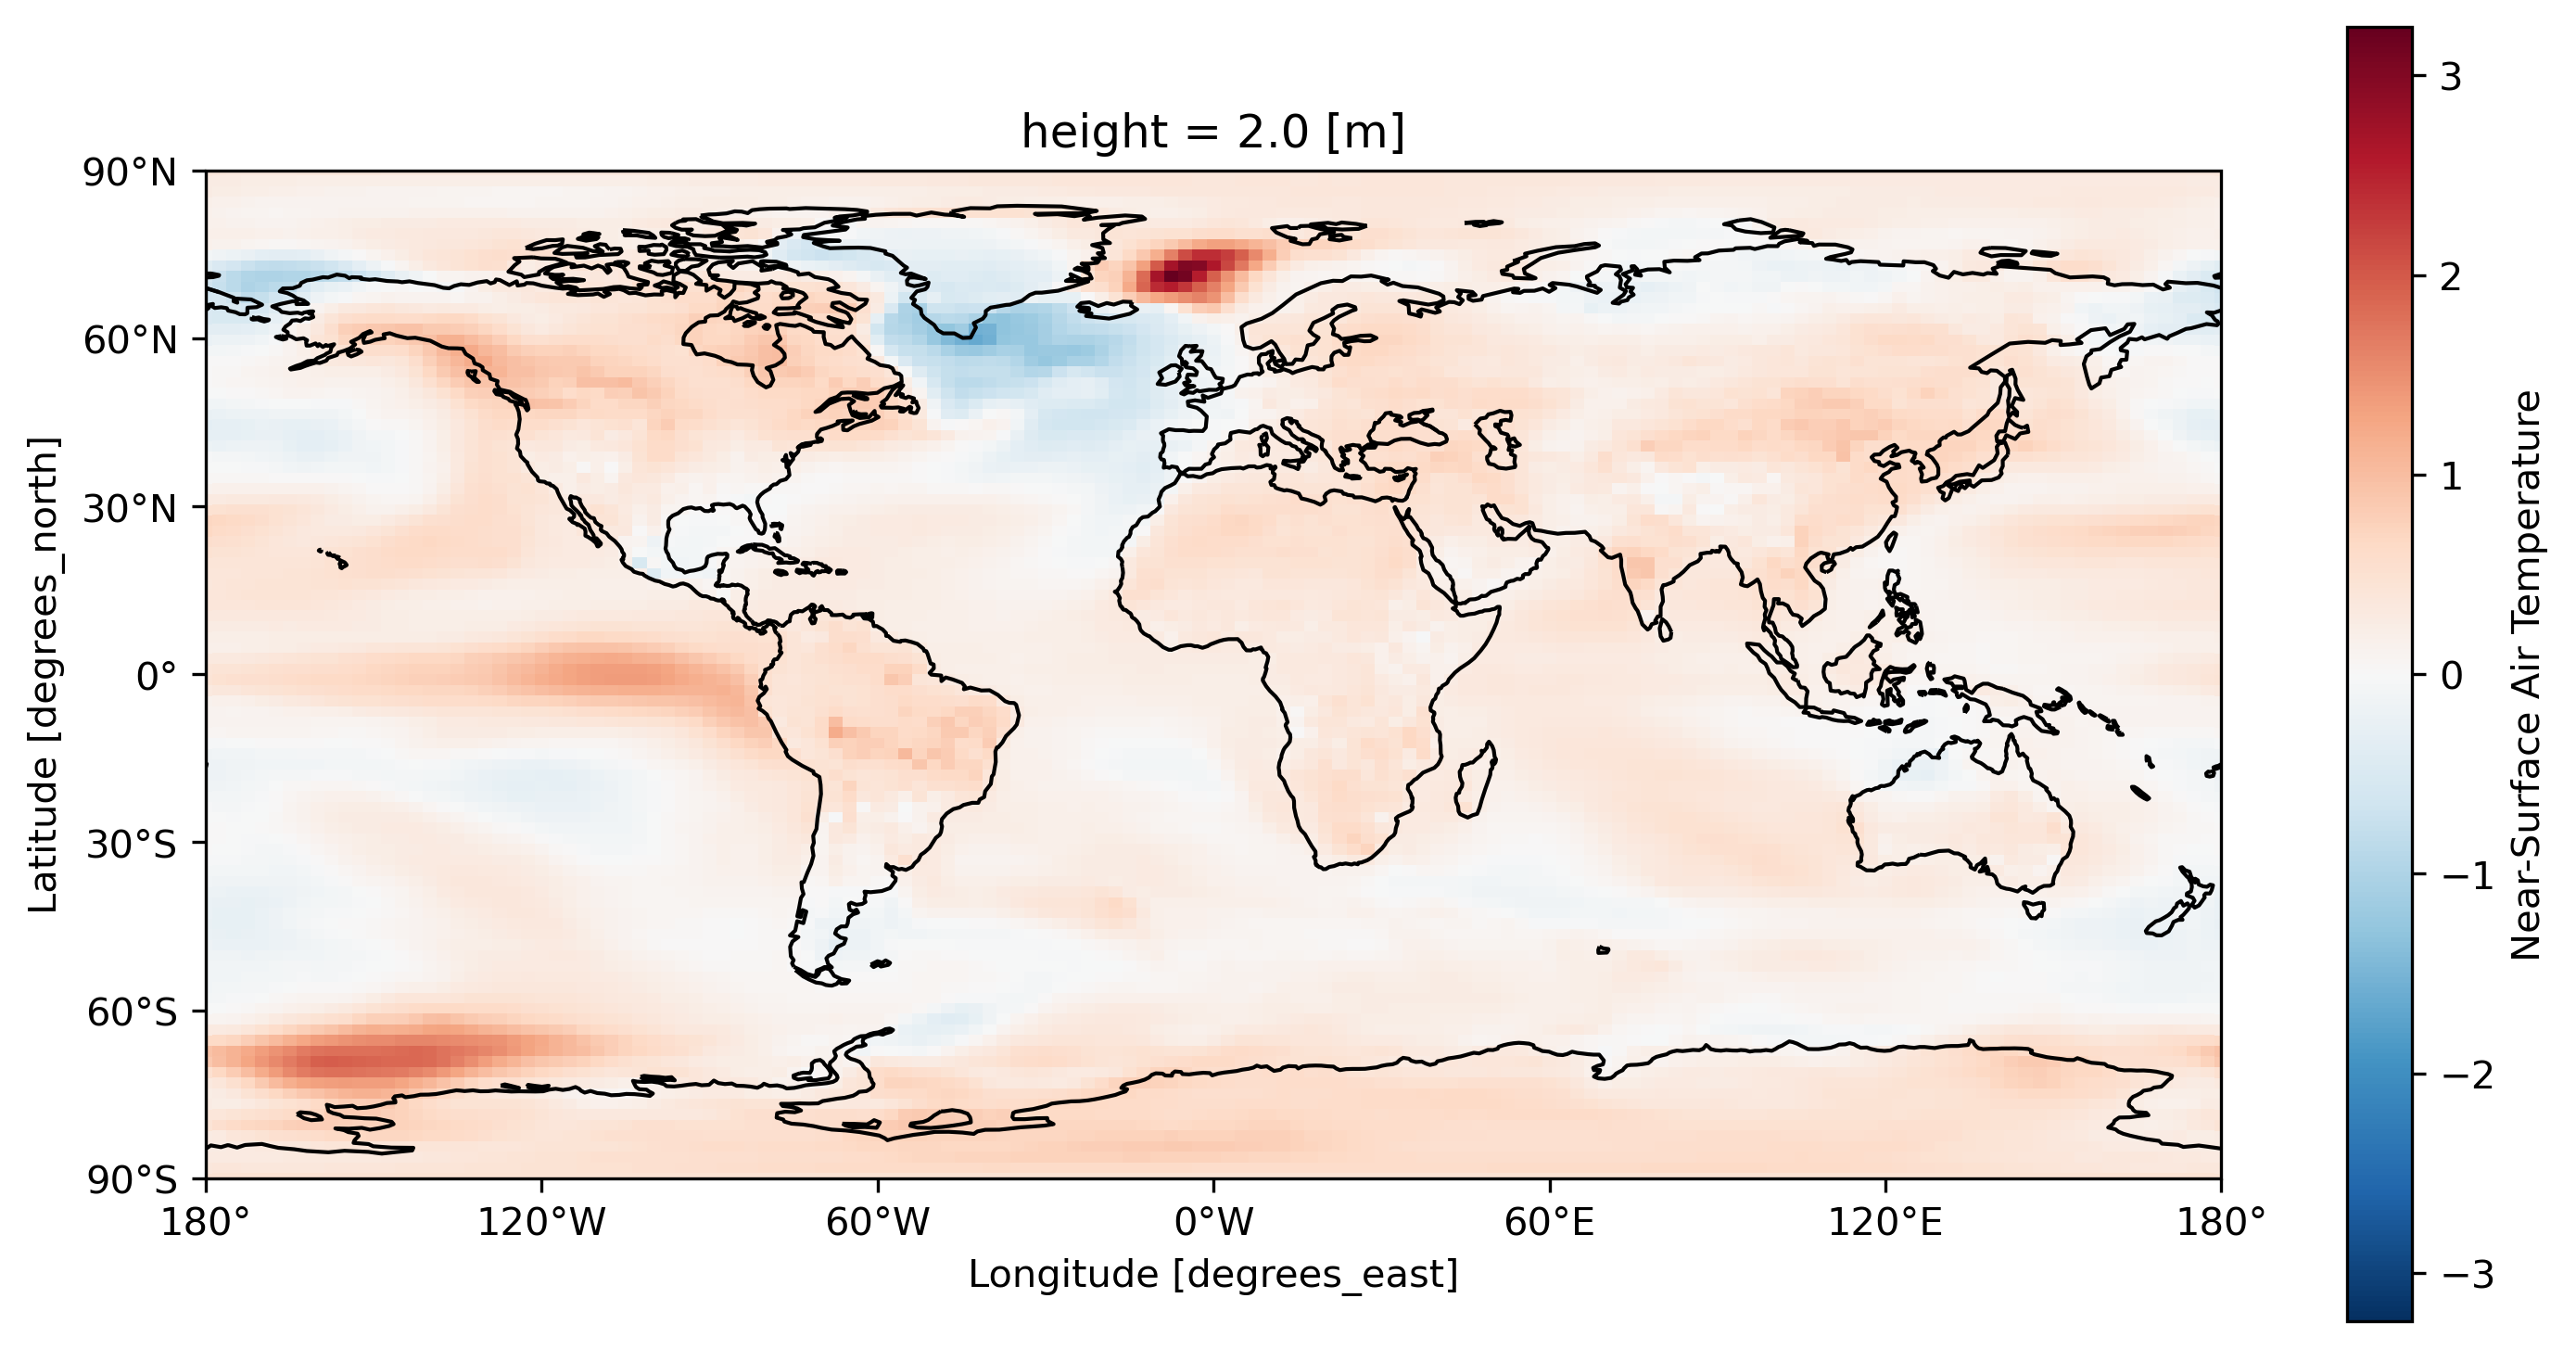

In [13]:
fig = plt.figure(1, figsize=(10,5), dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
plt.title(tas_NorESM.tas.long_name)
diff = post_SPG - pre_SPG
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree(),
                cbar_kwargs={"label": "Near-Surface Air Temperature"})
ax.coastlines()
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
   
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())

### COLORBAR ###
#cb = fig.colorbar(map, label=tas_NorESM.tas.long_name, extend='max', orientation="horizontal", shrink=0.5, pad=0.05)

plt.tight_layout()